### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
import pandas as pd
import numpy as np

!pip install seaborn
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)


In [2]:
df = pd.read_csv('CreditScoring.csv')

In [3]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
status_values = {
 0: 'unkown',
 1: 'ok',
 2: 'default'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [7]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [8]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan).max()

In [9]:
df = df[df.status != 'unkown'].reset_index(drop=True)

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,959.0,300000.0,30000.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,959.0,300000.0,30000.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,959.0,300000.0,30000.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,959.0,300000.0,30000.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,959.0,300000.0,30000.0,310,910


In [11]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.5, random_state=11)

In [12]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [13]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [14]:
#del df_train['status']
del df_val['status']
del df_test['status']

In [15]:
del df_train['status']

In [16]:
df_test

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,3,owner,36,26,single,no,freelance,35,959.0,300000.0,30000.0,800,1000
1,10,rent,60,28,married,no,fixed,78,959.0,300000.0,30000.0,2250,2250
2,14,rent,60,41,married,no,fixed,53,959.0,300000.0,30000.0,1150,2497
3,4,owner,60,39,married,no,freelance,45,959.0,300000.0,30000.0,1300,1508
4,1,other,30,20,single,no,fixed,35,959.0,300000.0,30000.0,450,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,19,owner,12,42,married,no,fixed,90,959.0,300000.0,30000.0,1100,2413
887,7,owner,36,24,married,no,fixed,45,959.0,300000.0,30000.0,1000,1597
888,0,owner,24,28,married,no,partime,45,959.0,300000.0,30000.0,600,943
889,8,other,36,30,married,yes,freelance,75,959.0,300000.0,30000.0,1220,1745


# 6.3 Decision Trees

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [18]:
train_dicts = df_train.to_dict(orient='records')

In [19]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [20]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [21]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [23]:
dt = DecisionTreeClassifier(max_depth=7)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [24]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.8966186147350804
val: 0.7072707584019802


In [25]:
from sklearn.tree import export_text

In [26]:
print(export_text(dt))

|--- feature_24 <= 0.50
|   |--- feature_26 <= 6.50
|   |   |--- feature_1 <= 1185.00
|   |   |   |--- feature_26 <= 1.50
|   |   |   |   |--- feature_23 <= 1596.00
|   |   |   |   |   |--- feature_27 <= 42.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_27 >  42.00
|   |   |   |   |   |   |--- feature_7 <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_7 >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_23 >  1596.00
|   |   |   |   |   |--- feature_6 <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_6 >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- feature_26 >  1.50
|   |   |   |   |--- feature_0 <= 37.50
|   |   |   |   |   |--- feature_26 <= 4.50
|   |   |   |   |   |   |--- feature_0 <= 34.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_0 >  34.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |---

# 6.4 Decision Tree Learning Algorithm
- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision Tree Learning Algorithm

# 6.5 Decision trees parameter tuning
- selecting max_depth
- selecting min_samples_leaf

In [27]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train,y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, auc))

   1 -> 0.624
   2 -> 0.707
   3 -> 0.728
   4 -> 0.731
   5 -> 0.719
   6 -> 0.725
  10 -> 0.640
  15 -> 0.630
  20 -> 0.627
None -> 0.633


In [28]:
scores = []

for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train,y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, s, auc))

In [29]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [30]:
df_scores.head()

,max_depth,min_samples_leaf,auc
0,4.0,1,0.730553
1,4.0,2,0.730553
2,4.0,5,0.730553
3,4.0,10,0.735181
4,4.0,15,0.736601


In [31]:
df_scores.sort_values(by='auc',ascending=False).head()

,max_depth,min_samples_leaf,auc
22,6.0,15,0.749562
50,15.0,20,0.748660
59,20.0,20,0.748145
68,NaN,20,0.748145
32,7.0,20,0.747807


In [32]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf',
                                  columns=['max_depth'],
                                  values=['auc'])
df_scores_pivot.round(3)

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.637  0.731  0.719  0.725  0.703  0.649  0.644  0.632
2                 0.666  0.731  0.722  0.728  0.708  0.663  0.667  0.664
5                 0.684  0.731  0.725  0.731  0.721  0.689  0.684  0.686
10                0.725  0.735  0.727  0.747  0.723  0.729  0.725  0.726
15                0.743  0.737  0.729  0.750  0.748  0.747  0.743  0.747
20                0.748  0.737  0.730  0.746  0.748  0.747  0.749  0.748
100               0.745  0.740  0.746  0.745  0.745  0.745  0.745  0.745
200               0.735  0.728  0.735  0.735  0.735  0.735  0.735  0.735
500               0.633  0.633  0.633  0.633  0.633  0.633  0.633  0.633

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

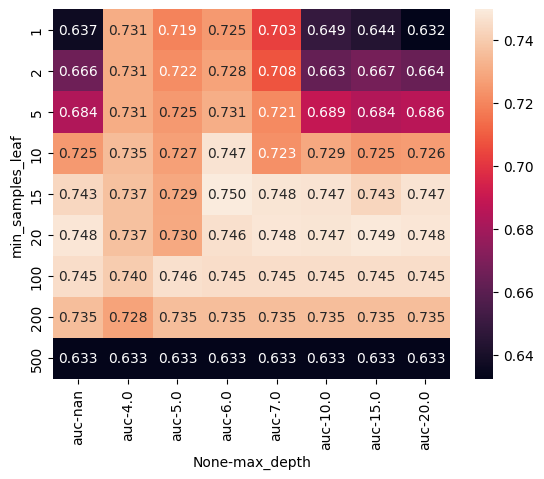

In [33]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [34]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

# 6.6 Random Forest
- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [37]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [38]:
roc_auc_score(y_val, y_pred)

0.7572788799938122

In [39]:
rf.predict_proba(X_val[[0]])

array([[0.5, 0.5]])

In [40]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=10,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [41]:
df_scores = pd.DataFrame(scores, columns=['s', 'n_estimators', 'auc'])

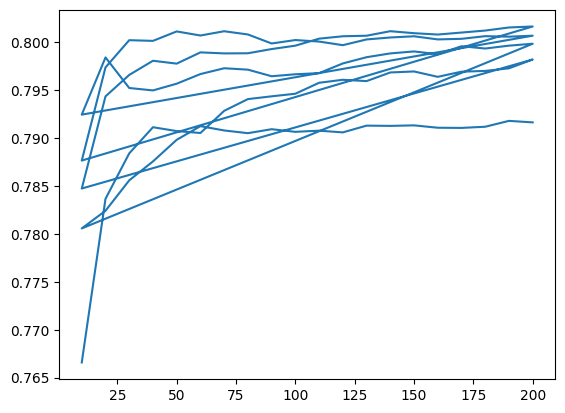

In [42]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [43]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,1,10,0.766579
1,1,20,0.783662
2,1,30,0.788407
3,1,40,0.791137
4,1,50,0.790733


In [44]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.766579
1,1,20,0.783662
2,1,30,0.788407
3,1,40,0.791137
4,1,50,0.790733


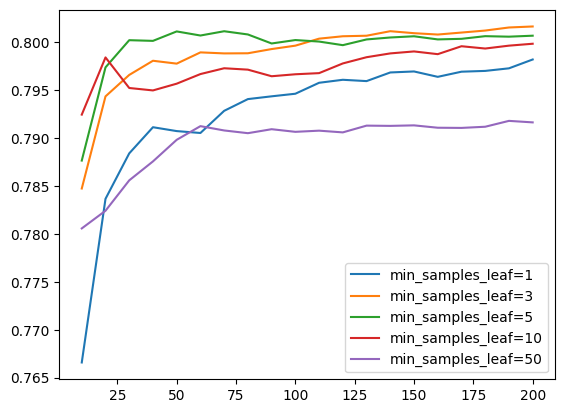

In [45]:
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators,
             df_subset.auc, 
             label='min_samples_leaf=%d' % s)
    
plt.legend()

In [46]:
rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=10,
                                    min_samples_leaf=3,
                                    random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

# 6.7 Gradient boosting and XGBoost
- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

In [47]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/ee/2c/03d466d00818c8e0ffcf778946ca4a5e05694a11b85bc51f1bc5c18ca54e/xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl.metadata
  Using cached xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl (297.1 MB)


In [48]:
import xgboost as xgb

In [49]:
features = dv.get_feature_names_out()
x = features.tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=x)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=x)

In [50]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [51]:
y_pred = model.predict(dval)

In [52]:
roc_auc_score(y_val, y_pred)

0.7869551765479367

In [53]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [54]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params,
                  dtrain,
                  verbose_eval=5,
                  evals=watchlist,
                  num_boost_round=200)

In [55]:
s = output.stdout.split('\n')
line = s[0]
num_iter, train_auc, val_auc = line.split('\t')
num_iter = int(num_iter.strip('[]'))

In [56]:
train_auc = float(train_auc.split(':')[1])

In [57]:
val_auc = float(val_auc.split(':')[1])

In [58]:
def parse_xgb_output(output):
    results = []
    tree = []
    aucs_train = []
    aucs_val = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
    
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [59]:
df_score = parse_xgb_output(output)

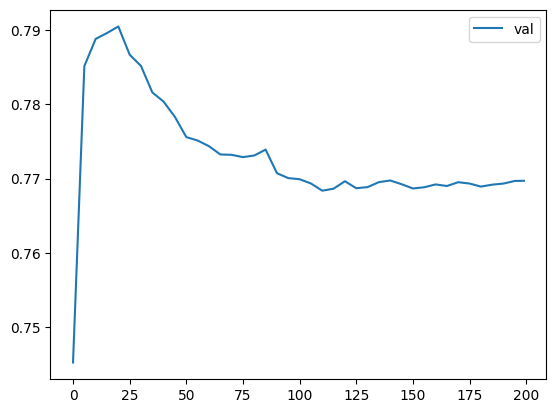

In [60]:
#plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

# 6.8 XGBoost parameter tuning
Tuning the following parameters:
- eta
- max_depth
- min_child_weight

In [61]:
scores = {}

In [62]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [63]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

In [64]:
scores.keys()

dict_keys(['min_child_weight=10'])

In [65]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_scores.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.79, 0.81)
plt.legend()

AttributeError: 'DataFrame' object has no attribute 'num_iter'

In [66]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=75)

# 6.9 Selecting the final model
- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [67]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [68]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7494164056155006

In [69]:
rf = RandomForestClassifier(n_estimators=200,
                                    max_depth=10,
                                    min_samples_leaf=3,
                                    random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [70]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.801652937309046

In [71]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=75)

In [72]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8053045596937

In [73]:
df_full_train = df_full_train.reset_index(drop=True)

In [74]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [75]:
del df_full_train['status']

In [76]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [77]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                   feature_names=dv.get_feature_names_out().tolist())

dtest = xgb.DMatrix(X_test,
                    feature_names=dv.get_feature_names_out().tolist())

In [78]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, 
                  dfulltrain, 
                  num_boost_round=75)

In [79]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8034981183715361